# 对比不同的优化算法

首先，我们将列出前面我们已经实现了的3种优化算法，然后运行它们，对它们进行比较。

In [6]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/explore/ai/10_comparison_of_optimization_algorithms")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - 梯度下降

In [8]:
def update_parameters_with_gd(parameters, grads, learning_rate):
 
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]        
    return parameters

## 2 - Mini-Batch梯度下降


In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    np.random.seed(seed)           
    m = X.shape[1]                
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

 
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
  
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
  
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
 
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 3 - 动量梯度下降

In [10]:
def initialize_velocity(parameters):
 
    L = len(parameters) // 2 
    v = {}
   
    for l in range(L):
   
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l+1)])
      
    return v

In [11]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
   
    L = len(parameters) // 2 
  
    for l in range(L):
        
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads['db' + str(l + 1)]
  
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
        
        
    return parameters, v

## 4 - Adam


In [12]:
def initialize_adam(parameters) :
       
    L = len(parameters) // 2 
    v = {}
    s = {}
    
   
    for l in range(L):

        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])
     
    return v, s

In [13]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
 
    L = len(parameters) // 2                 
    v_corrected = {}                        
    s_corrected = {}                        
    
    for l in range(L):
       
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
       
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
       
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)
       
    return parameters, v, s

## 5 - 对比不同的优化算法

首先加载我们虚构的数据集。

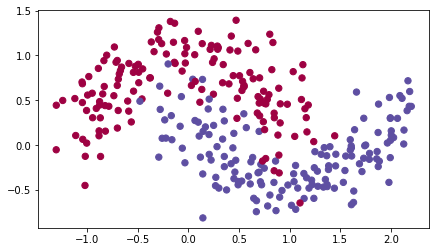

In [14]:
train_X, train_Y = load_dataset()

在自定义的工具库中，已经为大家实现了一个3层的神经网络的相关函数。下面的模型函数会调用它们。这个模型函数内部可以使用3种优化算法，通过optimizer参数来指定不同的优化算法: 
- optimizer == "gd"时是纯Mini-batch梯度下降算法: 它会调用我们前面实现的:
    - `update_parameters_with_gd()`
- optimizer == "momentum"时是Mini-batch **动量梯度下降**: 它会调用我们前面实现的:
    - `initialize_velocity()` 和 `update_parameters_with_momentum()`
- optimizer == "adam"时是Mini-batch **Adam梯度下降**: 它会调用我们前面实现的:
    - `initialize_adam()` 和 `update_parameters_with_adam()`

In [15]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    
    L = len(layers_dims)            
    costs = []                       
    t = 0                           
    seed = 10                      
    
    parameters = initialize_parameters(layers_dims)

    # 为不同的优化算法做初始化工作
    if optimizer == "gd":
        pass # 纯的梯度下降不需要初始化任何变量
    elif optimizer == "momentum":
        v = initialize_velocity(parameters) # 初始化v
    elif optimizer == "adam":
        v, s = initialize_adam(parameters) # 初始化v和s
    
    # 一个epoch就是遍历整个数据集一遍，一个epoch里面可以有多个minibatch
    for i in range(num_epochs):
        
        # 下面的seed进行了加1处理，是为了让每个epoch中的洗牌后数据集都不同。这样一来，每次的minibatch都包含了不同的训练样本。
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        # 遍历每个minibatch
        for minibatch in minibatches:

            # 分出x和y
            (minibatch_X, minibatch_Y) = minibatch

            a3, caches = forward_propagation(minibatch_X, parameters)

            cost = compute_cost(a3, minibatch_Y)

            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # 使用不同的优化算法来更新参数
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # 梯度下降的次数，用来进行修正指数加权平均值
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        if print_cost and i % 1000 == 0:
            print("Cost after epoch %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

下面我们将分别使用不同的优化算法来调用上面的模型.

### 5.1 - Mini-batch梯度下降

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


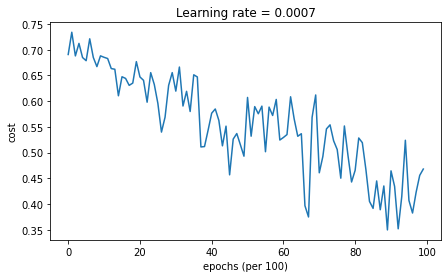

Accuracy: 0.7966666666666666


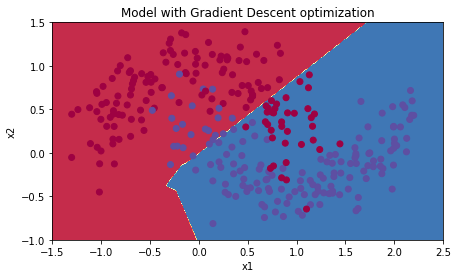

In [16]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())

### 5.2 - Mini-batch 动量梯度下降

下面是使用动量梯度下降时的情况。由于数据集太小，所以动量梯度下降的优势不是特别明显。数据集越大，效果越明显。

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740


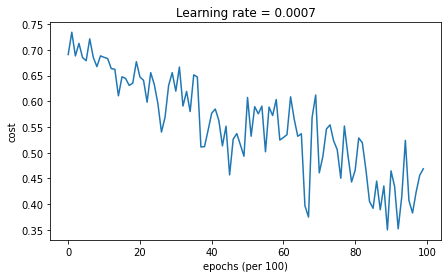

Accuracy: 0.7966666666666666


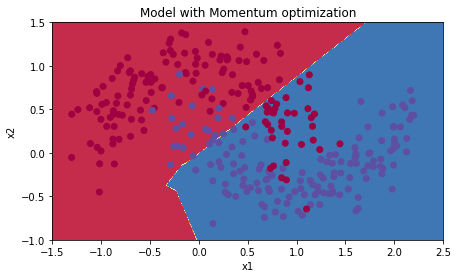

In [17]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9, optimizer="momentum")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())

### 5.3 - Mini-batch Adam梯度下降


Cost after epoch 0: 0.687550
Cost after epoch 1000: 0.173593
Cost after epoch 2000: 0.150145
Cost after epoch 3000: 0.072939
Cost after epoch 4000: 0.125896
Cost after epoch 5000: 0.104185
Cost after epoch 6000: 0.116069
Cost after epoch 7000: 0.031774
Cost after epoch 8000: 0.112908
Cost after epoch 9000: 0.197732


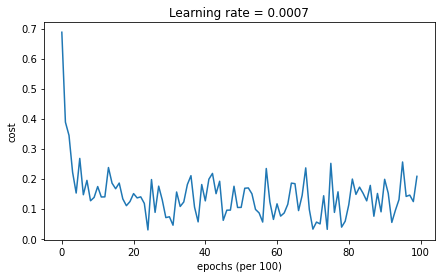

Accuracy: 0.94


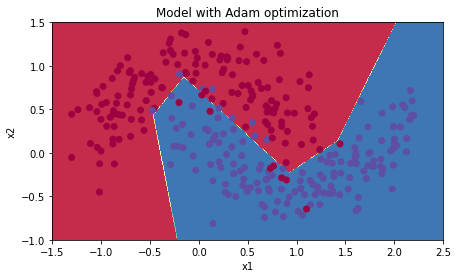

In [18]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="adam")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())

### 5.4 - 总结

<table> 
    <tr>
        <td>
        <b>优化算法</b>
        </td>
        <td>
        <b>精准度</b>
        </td>
        <td>
        <b>损失路径</b>
        </td>
    </tr>
        <td>
        标准梯度下降
        </td>
        <td>
        79.7%
        </td>
        <td>
        曲折
        </td>
    <tr>
        <td>
        动量梯度下降
        </td>
        <td>
        79.7%
        </td>
        <td>
        曲折
        </td>
    </tr>
    <tr>
        <td>
        Adam梯度下降
        </td>
        <td>
        94%
        </td>
        <td>
        平滑
        </td>
    </tr>
</table> 

从上面的结果来看，貌似动量梯度下降算法表现得并没有什么优势，那是因为我们的数据集太简单了，而且设置的学习率也太小了。在大数据集时，它其实是表现得不错的。

Adam的表现出类拔萃。其实，如果你让其它两个优化算法的训练epoch次数更多一些，它们也能达到Adam的精准度。Adam只是比它们学习得要快一些。